# Over the summer of 2014, car theft was much more common in Seattle than in San Francisco, while the difference was far less pronounced for thefts from cars
Author: Albert Wildeman

This notebook compares the frequency of car thefts and thefts from cars in Seattle in San Francisco over the summer of 2014. After loading the necessary libraries and initializing the graphical environment,

In [1]:
# import the necessary libraries and set up matplotlib graphics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#plt.style.use('seaborn-paper')
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

the raw data from each city can be loaded and used to compile the occurrences of each type of theft for each city:

In [2]:
# Load the raw data
df_Se = pd.read_csv('data\seattle_incidents_summer_2014.csv', low_memory=False)
df_SF = pd.read_csv('data\sanfrancisco_incidents_summer_2014.csv', low_memory=False)

# Get total number of reports of stolen cars and thefts from cars, for each city
# Source for Seattle police offense codes: data.seattle.gov/Public-Safety/SPD-Offense-Codes/22zb-azac/data
# It is assumed here that events filed as either grand theft and petty theft, and from either a locked car or an unlocked car 
# in SF are filed as carprowls in Seattle.
Se_cartheft_daily = df_Se.loc[ df_Se['Offense Code']=='2404', 'Date Reported'].apply(lambda x : x[:10]).value_counts().values
Se_carprowl_daily = df_Se.loc[ df_Se['Offense Code']=='2305', 'Date Reported'].apply(lambda x : x[:10]).value_counts().values
SF_cartheft_daily = df_SF.loc[ df_SF['Descript']=='STOLEN AUTOMOBILE', 'Date'].value_counts().values
SF_carprowl_daily = df_SF.loc[(df_SF['Descript']=='GRAND THEFT FROM LOCKED AUTO') | 
                              (df_SF['Descript']=='PETTY THEFT FROM LOCKED AUTO') | 
                              (df_SF['Descript']=='PETTY THEFT FROM UNLOCKED AUTO'), 'Date'].value_counts().values

# Create a new dataframe collecting the frequencies of daily counts for each crime in each city
cities = ["Seattle", "San Francisco"]
crimes = ["car thefts", "thefts from cars"]
daily_counts = pd.DataFrame(data = [[Se_cartheft_daily, SF_cartheft_daily], [Se_carprowl_daily, SF_carprowl_daily]], 
                            columns = cities, index = crimes)

With the data prepared, let's have a look at the distribution of occurrences per day for each crime and city:

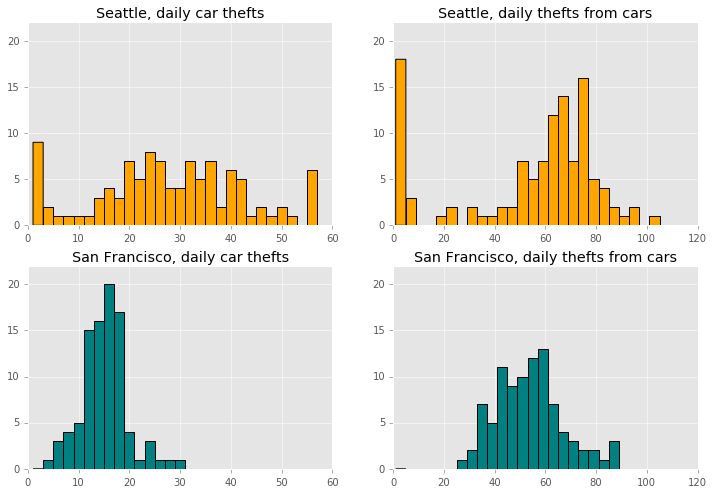

In [3]:
f, axarr = plt.subplots(2, 2)
colors = ['orange','teal']
for icity in [0,1]:
    for icrime in [0,1]:
        axarr[icity, icrime].hist(daily_counts.loc[crimes[icrime], cities[icity]], 
                                  bins=range(1,60+60*icrime,2*(icrime+1)), color=colors[icity], edgecolor='black',linewidth=1)
        axarr[icity, icrime].xaxis.tick_bottom()
        axarr[icity, icrime].yaxis.tick_left()
        axarr[icity, icrime].set(title=(cities[icity] + ", daily " + crimes[icrime]), ylim=(0,22), xlim=(0,60+60*icrime))

The distributions are quite far from normal, at least for Seattle. Because of this (and frankly, to take the method for a spin), I'll use the bootstrap rather than a normal approximation here to generate confidence intervals for the overall counts for the entire summer of 2014.

In [5]:
total_counts = daily_counts.applymap(sum)
# define function to perform the bootstrap sampling
def bootstrap_sum(data, num_samples, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    #stat = np.sort(statistic(samples, 0))
    stat = np.sort(samples.sum(axis=1), 0)
    return np.array([stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)]])

n_samples = 10000
alpha = 0.05
total_ci = daily_counts.applymap(lambda  x : bootstrap_sum(x,n_samples, alpha))
total_err = abs(total_ci - total_counts)

## Occurences per month, per 100,000 population
Let's start by comparing the occurences for each type of crime between the cities, per month per 100,000 population:

In [6]:
# Population for each city as of the 2010 census:
populations = pd.Series(data = [608660, 820445], index=cities)
pop_factor = 100000/(populations*3)
pop_counts = total_counts.multiply(pop_factor)
# convert error bars to this scale as well:
pop_err = total_err.multiply(pop_factor)

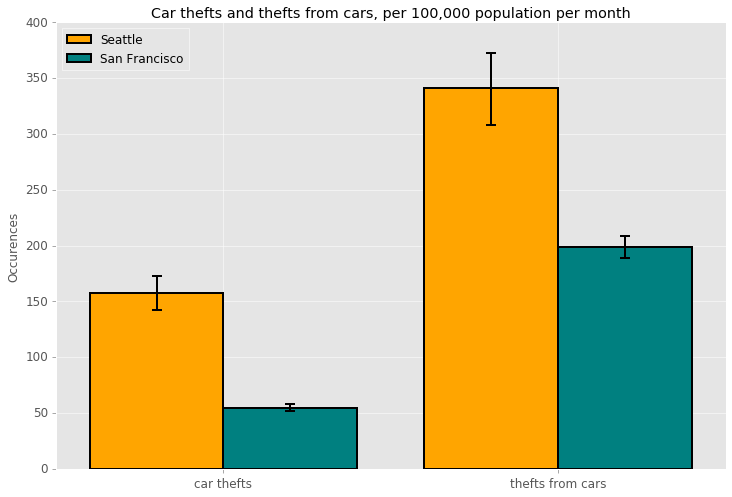

In [7]:
def make_bargraph(data, errors, title, ylabel, ylim):
    # open a figure
    fig, ax = plt.subplots()
    ind = np.arange(2)  # the x locations for the groups
    width = 0.4     # the width of the bars

    # Create bar graphs for the thefts of each type, per city:
    bars=[[],[]]
    for icity, city in enumerate(cities):
        errorbars = [[errors[city][crime][error_side] for crime in crimes] for error_side in [0,1]]
        bars[icity] = ax.bar(ind+0.1+width*icity, data[city].values, width, color=colors[icity], yerr=errorbars,
                                error_kw={'ecolor':'black', 'linewidth':2, 'capthick':2, 'capsize':5},
                                 edgecolor='black',linewidth=2)

    # labels, title, ticks, legend
    ax.set(title=title, ylabel=ylabel, xticks=(ind + 0.1 + width), xticklabels=crimes, ylim=(0,ylim) )
    ax.tick_params(labelsize=12)
    ax.xaxis.tick_bottom(); ax.yaxis.tick_left()
    ax.legend((bars[0][0], bars[1][0]), cities, loc='upper left');

make_bargraph(pop_counts, pop_err, 'Car thefts and thefts from cars, per 100,000 population per month', 'Occurences', 400);

This graph shows that thefts from cars are more common than car thefts in both cities, which is unsurprising given the risks involved with each type of theft. More interestingly, both are much more common in Seattle than in San Francisco, with the difference being more pronounced for car thefts.
## Occurrences as a percentage of total police reports
To investigate whether the differences between the cities are specific to these types of thefts or simply reflect generally different crime levels, let us have a look instead at the percentage of police reports in either city that is due to these types of thefts:

In [10]:
# Total reports:
reports = pd.Series(data = [df_Se.shape[0], df_SF.shape[0]], index=cities)
reports_factor = 100/reports
reports_counts = total_counts.multiply(reports_factor)
# convert error bars to this scale as well:
reports_err = total_err.multiply(reports_factor)

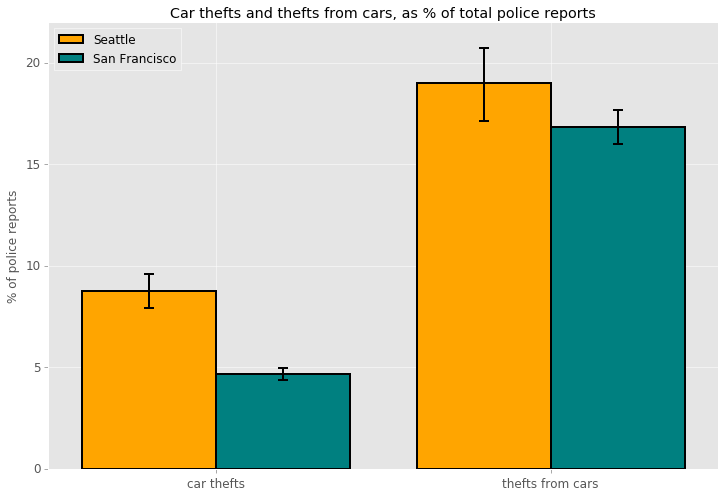

In [12]:
make_bargraph(reports_counts, reports_err, 'Car thefts and thefts from cars, as % of total police reports', 
              '% of police reports', 22);

This graph reveals that when general crime levels are taken into account the number of thefts from cars is not significantly different between the two cities, whereas the difference is indeed significant for car thefts: the number in Seattle is still about double the number in San Francisco.